In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import logistic
# from scipy.special import logit

import torch
# import torch.nn.functional as F
# from torchvision import transforms
# from torch.utils.data import Dataset
# from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *




Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "ordinal_dev"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/ordinal_dev/configuration.json


# 2.  Data

Setting seed: 42


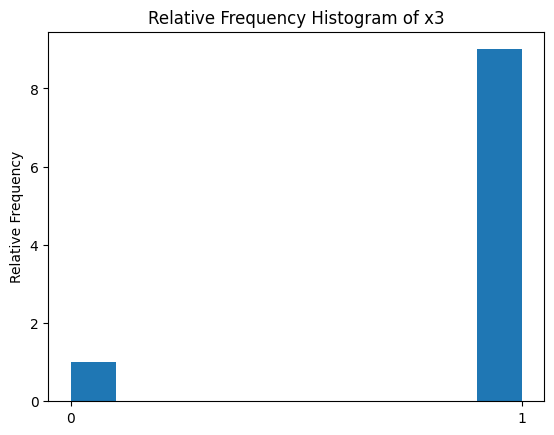

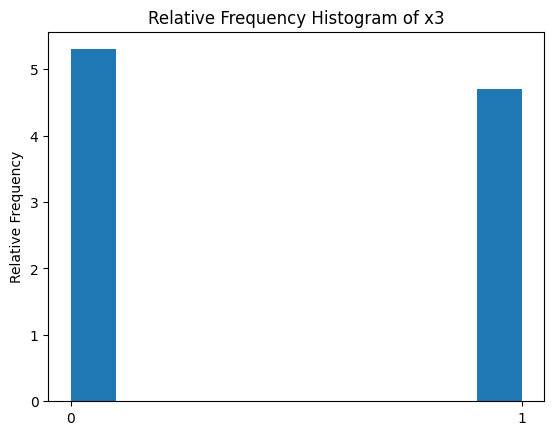

Setting seed: 42
   x1  x2        x3
0   1   0 -0.377983
1   0   0 -0.826880
2   1   1  1.273521
3   1   1  1.867366
4   1   1  2.413585
Configuration updated successfully.


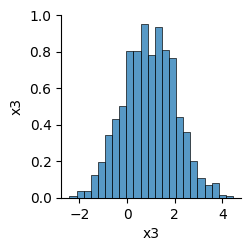

In [3]:


def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Modified data-generating process.

    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x1 and x2 are
        binary ordered categoricals, and x3 is continuous.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample binary X1 ---
    if doX[0] is None:
        x1_num = np.random.binomial(n=1, p=0.9, size=n_obs)
    else:
        x1_num = np.full(n_obs, doX[0], dtype=int)
    x1 = pd.Categorical(x1_num, categories=[0, 1], ordered=True)

    # --- 2. Sample binary X2 ---
    if doX[1] is None:
        x2_num = np.random.binomial(n=1, p=0.45, size=n_obs)
    else:
        x2_num = np.full(n_obs, doX[1], dtype=int)
    x2 = pd.Categorical(x2_num, categories=[0, 1], ordered=True)

    # --- 3. Sample continuous X3 ---
    if doX[2] is None:
        noise = np.random.normal(loc=0.0, scale=1.0, size=n_obs)
        x3 = 0 + 0.5 * x1_num + f(x2_num) + noise
    else:
        x3 = np.full(n_obs, doX[2], dtype=float)

    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})



df = dgp(n_obs=1_000, seed=42)


plt.hist(df['x1'], density=True)
plt.xticks([0, 1])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram of x3')
plt.show()


plt.hist(df['x2'], density=True)
plt.xticks([0, 1,])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram of x3')
plt.show()

import seaborn as sns
sns.pairplot(df)

EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=1_000, seed=42)
    df['x1']=df['x1'].astype(int)
    df['x2']=df['x2'].astype(int)

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    df['x2']=df['x2'].astype(int)
    df['x1']=df['x1'].astype(int)

    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'ord','x2':'ord','x3':'cont'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   int64  
 1   x2      1000 non-null   int64  
 2   x3      1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 800, Validation size: 100, Test size: 100


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [7]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [8]:
write_nodes_information_to_configuration_v2(CONF_DICT_PATH, min_vals, max_vals,levels_dict={'x1': 2,'x2': 2})

{'x1': {'Modelnr': 0, 'data_type': 'ord', 'levels': 2, 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.0, 'max': 1.0, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'ord', 'levels': 2, 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'ord'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': 0.0, 'max': 1.0, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'cont', 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'ord', 'x2': 'ord'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': -0.8829760308059689, 'max': 2.7365581647527457, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift'), 'x2': np.str_('LinearShift')}}}
Configuration updated successfully.


In [9]:
df

,x1,x2,x3
0,1,0,-0.377983
1,0,0,-0.826880
2,1,1,1.273521
3,1,1,1.867366
4,1,1,2.413585
...,...,...,...
995,1,1,0.935226
996,0,1,2.021383
997,1,0,2.588443
998,0,0,-1.585983


In [18]:
class GenericDataset_v3(Dataset):
    def __init__(
        self,
        df,
        target_col,
        target_nodes=None,
        parents_dataype_dict=None,
        transform=None,
        transformation_terms_in_h=None
    ):
        """
        df: pd.DataFrame
        target_col: str
        target_nodes: dict mapping each node → metadata (including 'data_type')
        parents_dataype_dict: dict var_name → "cont"|"ord"|"other"
        transform: torchvision transform for images
        transformation_terms_in_h: dict for intercept logic
        """
        
        
        
        self.df = df.reset_index(drop=True)
        self.target_col = target_col
        self.target_nodes = target_nodes or {}
        self.parents_dataype_dict = parents_dataype_dict or {}
        self.variables = list(self.parents_dataype_dict.keys())
        self.transform = transform
        self.transformation_terms_in_h = transformation_terms_in_h or {}
                # If we know this target is ordinal, record #classes
        if (
            self.target_nodes
            and self.target_col in self.target_nodes
            and self.target_nodes[self.target_col].get('data_type') == "ord"
        ):
            self.target_num_classes = int(self.df[self.target_col].nunique())
        else:
            self.target_num_classes = None

        self._check_binary_values_of_df()
        
    def _transform_y(self,row):
        # handle y
        if self.target_num_classes is not None:
            # ordinal source → one-hot
            raw = row[self.target_col]
            y_int = int(raw)
            y = F.one_hot(torch.tensor(y_int, dtype=torch.long), num_classes=self.target_num_classes).float()
            
        else:
            # continuous or other
            y = torch.tensor(row[self.target_col], dtype=torch.float32)
        return y

    def _check_binary_values_of_df(self):
        for var in self.variables:
            dtype = self.parents_dataype_dict[var]
            if dtype != "ord":
                continue

            unique_vals = set(self.df[var].dropna().unique())
            if len(unique_vals) == 2:
                if unique_vals != {0, 1}:
                    raise ValueError(
                        f"Variable '{var}' is marked as ordinal with 2 classes, "
                        f"but values are {unique_vals}. Please provide binary ordinal variables as 0 and 1."
                    )
            elif len(unique_vals) < 2:
                raise ValueError(
                    f"Variable '{var}' has fewer than 2 unique values: {unique_vals}. "
                    "Binary ordinal variables must have exactly two distinct values: 0 and 1."
                )
                        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x_data = []

        # --- SOURCE NODE: no parents → x = [1.0] ---
        if not self.parents_dataype_dict:
            x_data = [torch.tensor(1.0)]
            y=self._transform_y(row)
            return tuple(x_data), y

        # --- INTERCEPT if needed ---
        if all('i' not in str(v) for v in self.transformation_terms_in_h.values()):
            x_data.append(torch.tensor(1.0))

        # --- BUILD FEATURES ---
        for var in self.variables:
            dtype = self.parents_dataype_dict[var]
            ## Continous  feature
            if dtype == "cont":
                x_data.append(torch.tensor(row[var], dtype=torch.float32))
                
            ## Ordinal feature , if it has more thatn 2 classes it uses onehotencodig, if binary use just 0 and 1
            elif dtype == "ord":
                x_ord = int(row[var])
                var_num_classes=int(self.df[var].nunique())
                if var_num_classes>2:
                    x_ord_onehot = F.one_hot(torch.tensor(x_ord, dtype=torch.long),num_classes=var_num_classes).float()
                    x_data.append(x_ord_onehot)
                
                else:
                    x_data.append(torch.tensor(x_ord, dtype=torch.long))
                
            else:  # "other"
                img = Image.open(row[var]).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                x_data.append(img)

        # --- BUILD TARGET ---
        y=self._transform_y(row)
            
            
        return tuple(x_data), y



def get_dataloader_v3(node, target_nodes, train_df, val_df, batch_size=32, verbose=False):
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    if target_nodes[node]['node_type'] == 'source':
        if verbose:
            print('Source node → features are just a constant 1.')
        train_ds = GenericDataset_v3(train_df,target_col=node,target_nodes=target_nodes,parents_dataype_dict=None,transform=transform)
        val_ds = GenericDataset_v3(val_df,target_col=node,target_nodes=target_nodes,parents_dataype_dict=None,transform=transform)
        
    else:
        parents_dataype_dict, transformation_terms_in_h, _ = ordered_parents(node, target_nodes)
        if verbose:
            print(f"Parents dtype: {parents_dataype_dict}")
        train_ds = GenericDataset_v3(train_df,target_col=node,target_nodes=target_nodes,parents_dataype_dict=parents_dataype_dict,transform=transform,transformation_terms_in_h=transformation_terms_in_h)
        val_ds = GenericDataset_v3(val_df,target_col=node,target_nodes=target_nodes,parents_dataype_dict=parents_dataype_dict,transform=transform,transformation_terms_in_h=transformation_terms_in_h)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [16]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 1#4112
epochs = 10# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [20]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']


for node in target_nodes:
    
    print(node)
    

    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader_v3(node, target_nodes, train_df, val_df, batch_size=batch_size, verbose=True)
    print(next(iter(train_loader)))
    


x1
Source node → features are just a constant 1.
[[tensor([1.])], tensor([[0., 1.]])]
x2
Parents dtype: OrderedDict([('x1', 'ord')])
[[tensor([1.]), tensor([1])], tensor([[0., 1.]])]
x3
Parents dtype: OrderedDict([('x1', 'ord'), ('x2', 'ord')])
[[tensor([1.]), tensor([1]), tensor([1])], tensor([2.2308])]


In [9]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 10# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [10]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']


for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    
    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model_v2(node, target_nodes, verbose=True).to(device)

    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader_v2(node, target_nodes, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop_v3(
                   node,
                   target_nodes,
                   NODE_DIR,
                   tram_model,
                   train_loader,
                   val_loader,
                   epochs,
                   optimizer,
                   use_scheduler,
                   scheduler,
                   save_linear_shifts=False,
                   verbose=1,
                   device=device)
    



----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Source → SimpleIntercept only
Source node → features are just a constant 1.
No existing model found. Starting fresh...
Saved new best model.
Epoch 1/10 | Train Loss: 0.9854 | Val Loss: 1.0091
  [Train: 0.75s | Val: 0.22s | Save: 0.00s | Total: 0.97s]
Saved new best model.
Epoch 2/10 | Train Loss: 0.9792 | Val Loss: 0.9974
  [Train: 0.29s | Val: 0.22s | Save: 0.00s | Total: 0.51s]
Saved new best model.
Epoch 3/10 | Train Loss: 0.9688 | Val Loss: 0.9857
  [Train: 0.29s | Val: 0.22s | Save: 0.00s | Total: 0.51s]
Saved new best model.
Epoch 4/10 | Train Loss: 0.9526 | Val Loss: 0.9742
  [Train: 0.30s | Val: 0.22s | Save: 0.00s | Total: 0.53s]
Saved new best model.
Epoch 5/10 | Train Loss: 0.9438 | Val Loss: 0.9628
  [Train: 0.30s | Val: 0.24s | Save: 0.00s | Total: 0.54s]
Saved new best model.
Epoch 6/10 | Train Loss: 0.9346 | Val Loss: 0.9515
  [Train: 0.30s | Val: 0.22s | Save: 0

RuntimeError: expected mat1 and mat2 to have the same dtype, but got: long int != float

# 6 Inspect Training

## 6.1 Loss vs epochs

In [ ]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()

In [ ]:
show_hdag_for_source_nodes_v2(target_nodes,EXPERIMENT_DIR,device,xmin_plot=0,xmax_plot=1)

In [ ]:
EXPERIMENT_DIR

In [ ]:

from utils.loss_ordinal import transform_intercepts_ordinal

def show_hdag_for_single_source_node_ordinal(node,target_nodes,EXPERIMENT_DIR,device):
        verbose=False
        n=1000
        #### 0.  paths
        NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
        
        ##### 1.  load model 
        model_path = os.path.join(NODE_DIR, "best_model.pt")
        tram_model = get_fully_specified_tram_model_v2(node, target_nodes, verbose=verbose)
        tram_model = tram_model.to(device)
        tram_model.load_state_dict(torch.load(model_path))
        _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
        
        #### 2. Sampling Dataloader
        dataset = SamplingDataset(node=node,EXPERIMENT_DIR=EXPERIMENT_DIR,number_of_samples=n, target_nodes=target_nodes, transform=None)
        sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
        output_list = []
        with torch.no_grad():
            for x in tqdm(sample_loader, desc=f"h() for  {node}"):
                x = [xi.to(device) for xi in x]
                int_input, shift_list = preprocess_inputs(x,ordered_transformation_terms_in_h, device=device)
                model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
                output_list.append(model_outputs)
                break
        if verbose:
            print("source node, Defaults to SI and 1 as inputs")
            
        int_out =     output_list[0]['int_out'][0]  # Shape: (20,)
        
        theta_single=transform_intercepts_ordinal(int_out)
        thetas_expanded = theta_single.repeat(n, 1).to(device)  # Shape: (n, 20)
        return thetas_expanded
        
        
thetas_expanded=show_hdag_for_single_source_node_ordinal('x1',target_nodes,EXPERIMENT_DIR,device)        
        

In [ ]:
thetas_expanded.shape

In [ ]:
inspect_trafo_standart_logistic_v2(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)

### Coefficient estimates

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check CS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()


# 7. Sample from Graph

In [ ]:
def sample_full_dag_chandru(target_nodes_dict,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    """
    Samples data for all nodes in a DAG defined by `conf_dict`, ensuring that each node's
    parents are sampled before the node itself. Supports interventions on any subset of nodes.

    Parameters
    ----------
    conf_dict : dict
        Dictionary defining the DAG. Each key is a node name, and each value is a config
        dict that includes at least:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node

    EXPERIMENT_DIR : str
        Base directory where all per-node directories are located.

    device : torch.device
        The device to run computations on (e.g., 'cuda' or 'cpu').

    do_interventions : dict, optional
        A dictionary specifying interventions for some nodes. Keys are node names (str),
        values are floats. For each intervened node, the specified value is used as the
        sampled value for all samples, and the model is bypassed. e.g. {'x1':1.0}

    n : int, optional
        Number of samples to draw for each node (default is 10_000).

    batch_size : int, optional
        Batch size for model evaluation during sampling (default is 32).

    delete_all_previously_sampled : bool, optional
        If True, removes previously sampled data before starting (default is True).

    verbose : bool, optional
        If True, prints debug/status information (default is True).

    Notes
    -----
    - The function ensures that nodes are only sampled after their parents.
    - Nodes with `node_type='source'` are treated as having no parents.
    - If a node is in `do_interventions`, `sampled_chandrupatla.pt` and a dummy `latents.pt`
      are created, enabling downstream nodes to proceed.
    - Sampling is done using a vectorized root-finding method (Chandrupatla's algorithm).
    """


    # delete the previolusly sampled data
    if delete_all_previously_sampled:
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    
    # repeat process until all nodes are sampled
    processed_nodes=[] # stack
    while set(processed_nodes) != set(target_nodes_dict.keys()): 
        for node in target_nodes_dict: # for each node in the conf dict
            if node in processed_nodes:
                if verbose :
                    print('node is already  in sampled list')
                continue
            
            _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes_dict)

            
            print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
            ## 1. Paths 
            NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
            SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
            os.makedirs(SAMPLING_DIR, exist_ok=True)
            
            
            ## 2. Check if sampled and latents already exist 
            if check_sampled_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
                processed_nodes.append(node)
                continue
            
            ## 3. logic to make sure parents are always sampled first
            skipping_node = False
            if target_nodes_dict[node]['node_type'] != 'source':
                for parent in target_nodes_dict[node]['parents']:
                    if not check_sampled_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
                        skipping_node = True
                        break
                    
            if skipping_node:
                print(f"Skipping {node} as parent {parent} is not sampled yet.")
                continue
            
            
            
            ## INTERVENTION, if node is to be intervened on , data is just saved
            if node in do_interventions.keys():
                intervention_value = do_interventions[node]
                intervention_vals = torch.full((n,), intervention_value)
                sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
                torch.save(intervention_vals, sampled_path)
                ### dummy latents jsut for the check , not needed
                dummy_latents = torch.full((n,), float('nan'))  
                latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
                torch.save(dummy_latents, latents_path)
                processed_nodes.append(node)
                
            ## no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
            else:
                ### sampling latents
                latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
                #latent_sample = truncated_logistic_sample(n=n, low=0, high=1, device=device)
                
                if verbose:
                    print("-- sampled latents")
                
                ### load modelweights
                model_path = os.path.join(NODE_DIR, "best_model.pt")
                tram_model = get_fully_specified_tram_model(node, target_nodes_dict, verbose=verbose).to(device)
                tram_model.load_state_dict(torch.load(model_path))
                
                if verbose:
                    print("-- loaded modelweights")
                
                
                # TODO samples for ordinal target
                
                if 
                    
                dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, conf_dict=target_nodes_dict, transform=None)
                sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                
                output_list = []
                with torch.no_grad():
                    for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
                        x = [xi.to(device) for xi in x]
                        
                        print(f"x {x}")
                        int_input, shift_list = preprocess_inputs(x,ordered_transformation_terms_in_h.values(), device=device)
                        
                    
                        if int_input is not None:
                            print(f"int_input {int_input.shape}")
                        if shift_list is not None:
                            print(f"shift_list {[s.shape for s in shift_list]}") 
                        
                        print([t.shape for t in x])
                        
                        model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
                        
                        print(f"model_outputs {model_outputs}")
                        
                        output_list.append(model_outputs)
                        
                if target_nodes_dict[node]['node_type'] == 'source':
                    if verbose:
                        print("source node, Defaults to SI and 1 as inputs")
                    theta_single = output_list[0]['int_out'][0]
                    theta_single = transform_intercepts_continous(theta_single)
                    thetas_expanded = theta_single.repeat(n, 1)
                    shifts = torch.zeros(n, device=device)
                else:
                    if verbose:
                        print("node has parents, previously sampled data is loaded for each pa(node)")
                    y_pred = merge_outputs(output_list, skip_nan=True)
                    shifts = y_pred['shift_out']
                    if shifts is None:
                        print("shift_out was None; defaulting to zeros.")
                        shifts = torch.zeros(n, device=device)
                    thetas = y_pred['int_out']
                    thetas_expanded = transform_intercepts_continous(thetas).squeeze()
                    shifts = shifts.squeeze()
                
                
                
                low = torch.full((n,), -1e5, device=device)
                high = torch.full((n,), 1e5, device=device)
                min_vals = torch.tensor(target_nodes_dict[node]['min'], dtype=torch.float32).to(device)
                max_vals = torch.tensor(target_nodes_dict[node]['max'], dtype=torch.float32).to(device)
                min_max = torch.stack([min_vals, max_vals], dim=0)
                
                ## Root finder using Chandrupatla's method
                def f_vectorized(targets):
                    return vectorized_object_function(
                        thetas_expanded,
                        targets,
                        shifts,
                        latent_sample,
                        k_min=min_max[0],
                        k_max=min_max[1]
                    )
                    
                root = chandrupatla_root_finder(
                    f_vectorized,
                    low,
                    high,
                    max_iter=10_000,
                    tol=1e-9
                )
                
                ## Saving
                sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
                latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
                
                if torch.isnan(root).any():
                    print(f'Caution! Sampling for {node} consists of NaNs')
                    
                torch.save(root, sampled_path)
                torch.save(latent_sample, latents_path)
                
                processed_nodes.append(node)

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            n= 100,
                            batch_size = 2,
                            delete_all_previously_sampled=True,
                            verbose=True)     

# TODO Fix bug with x6 sampling , training works, sampling has issue 

In [ ]:
# training funktionerit 
#   (nn_int): ComplexInterceptDefaultTabular(
#     (fc1): Linear(in_features=2, out_features=8, bias=True)
#     (relu1): ReLU()
#     (fc2): Linear(in_features=8, out_features=8, bias=True)
#     (relu2): ReLU()
#     (fc3): Linear(in_features=8, out_features=20, bias=False)
#   )
#   (nn_shift): ModuleList(
#     (0-1): 2 x ComplexShiftDefaultTabular(
#       (fc1): Linear(in_features=1, out_features=64, bias=True)
#       (relu1): ReLU()
#       (fc2): Linear(in_features=64, out_features=128, bias=True)
#       (relu2): ReLU()
#       (fc3): Linear(in_features=128, out_features=64, bias=True)
#       (relu3): ReLU()
#       (fc4): Linear(in_features=64, out_features=1, bias=False)
#     )
#     (2): LinearShift(
#       (fc): Linear(in_features=1, out_features=1, bias=False)
#     )
#   )
# )
# Existing model found. Loading weights and history...
# Continuing training from epoch 3...
# int_input torch.Size([512, 2])  
# 
# shift_list [torch.Size([512, 1]), torch.Size([512, 1]), torch.Size([512, 1])]





## sampling does not work








## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')